## Background

Recently, [there has been speculation](https://apnews.com/c575bd1cc3b1456cb3057ef670c7fe2a) that the White House released a doctored video of an intern trying to take a microphone away from CNN reporter Jim Acosta. The claim is that the video was sped up and slowed down at certain points to make Acosta seem aggressive.

There's been a number of attempts to analyze the video frame-by-frame by hand. This is fairly subjective and error-prone. If the video's timeline has in fact been edited, there is an objective, mathematical way to determine exactly where and how. In this article, I will walk through these steps. Before we look at the video, though, let's cover some theory.

## Frame Rate Conversion

A video is just a series of images (**frames**) shown in quick succession. The number of different images that appear each second (**frame rate**) determines how smooth the video looks. In producing a video for the web, there is a trade-off between smooth video (high frame rate) and small file size (low frame rate.)

Unfortunately, converting between two frame rates is usually not straightforward. Each frame in a video represents an instant in time. When you change between frame rates, the new frames usually fall at instants in time that do not have corresponding frames in the original video.

For example, this timeline shows where frames fall in a 7 fps and 5 fps video. Notice how only the first and last line up.

![](https://bitaesthetics.com/img/doctor/offset.png)

This means that when we are converting the video, we (or our software) have to decide what to do when the frame times don't line up. One choice is to take the frame at the closest time. This way we don't have to modify any of the frames themselves, but the disadvantage is that we get jerky video because the resulting frames have uneven timing between them.

![](https://bitaesthetics.com/img/doctor/nearest.png)

As a more concrete example, here's what this looks like on a bouncing-ball animation:

![](https://bitaesthetics.com/img/doctor/bounce_nearest.png)

Another common approach is to blend between the two frames nearest to the instant, proportional to how close it is to each:

![](https://bitaesthetics.com/img/doctor/bounce_fade.png)

The same problems are encountered when converting from a lower frame-rate to a higher one.

## The Accusation

The White House is accused of modifying frame timings to produce a video that works in their favor in making Acosta seem more aggressive. To test this, we can line up the frames in each video. If the video is not modified, the frames will line up in a straight line. If the line has curvature, it means that the video is faster in some places than others.

The tricky part is that the video released by the White House appears to have had its frame rate changed *twice*. As a result, most frames in the resulting video are actually a blend of two frames in the original. For example, take this frame from the White House's video:

<img src="https://bitaesthetics.com/img/doctor/wh_030.jpeg" style="width: 50%" />

It appears to be a blend of these frames from the original video:

<img src="https://bitaesthetics.com/img/doctor/160.jpeg" style="width: 50%" />
<img src="https://bitaesthetics.com/img/doctor/161.jpeg" style="width: 50%" />

So far, none of this is evidence of tampering, just frame rate conversion. But the effect makes it a little harder to say definitively which frame in the C-Span video corresponds to each frame in the White House video. With a bit of math, though, we can reconstruct the original timeline.

## Analysis

First, let's download the videos (I've put a copy of both on S3) and convert them into a sequence of images (one for each frame.) There's a Python package called [moviepy](http://zulko.github.io/moviepy/) that uses [ffmpeg](https://ffmpeg.org/) under the hood; the cell below will install it if you don't already have it.

In [1]:
!pip install -q moviepy # install moviepy if we need it.
from moviepy.editor import VideoFileClip

def download_and_convert(vid_url, base):
    clip = VideoFileClip(vid_url)
    clip.write_images_sequence(base + '_%03d.jpeg', verbose=False)

download_and_convert(
    'https://s3.amazonaws.com/aws-website-staticfiles-25g9k/acosta-video/actual_clip.mp4',
    'actual_clip')

download_and_convert(
    'https://s3.amazonaws.com/aws-website-staticfiles-25g9k/acosta-video/twitter_clip.mp4',
    'twitter_clip')

371it [00:08, 41.35it/s]             
442it [00:09, 46.77it/s]             


Next, let's get some boilerplate out of the way.

In [2]:
%matplotlib inline
import numpy as np
from imageio import imread
from matplotlib import pyplot as plt
from PIL.Image import fromarray

twitter_clip = 'twitter_clip_{:03d}.jpeg'.format
actual_clip = 'actual_clip_{:03d}.jpeg'.format

You may have noticed above that the White House's video has a [chyron](https://en.wikipedia.org/wiki/Chyron) and the C-Span video does not. In order to line the frames up, we'll just select the rectangle that doesn't include any graphics. That's where all the action is, anyway.

The video clips are short enough that we can do everything in-memory, so let's load both clips into a tensor.

In [3]:
def read_image(fname):
    img = imread(fname)
    img = img[:550,:1000,:]  # crop to where the action is
    img = img.sum(2)         # convert to black and white
    return img

def read_video(index_to_filename, clip_start, clip_end):
    # Read each frame of the video into a tensor.
    tensor = np.stack([
        read_image(index_to_filename(i)) for i in range(clip_start, clip_end)
    ])
    # Flatten each frame into a vector.
    tensor = tensor.reshape((clip_end-clip_start, -1))
    # Transpose the result so that each column is a frame and each row is a pixel.
    return tensor.T

# Note: I've picked out the overlapping sections of each video by hand.
TWITTER_CLIP_START = 1
TWITTER_CLIP_END   = 106
ACTUAL_CLIP_START  = 133
ACTUAL_CLIP_END    = 240
actual_clip_frames = read_video(actual_clip, ACTUAL_CLIP_START, ACTUAL_CLIP_END)
twitter_clip_frames = read_video(twitter_clip, TWITTER_CLIP_START, TWITTER_CLIP_END)

The White House clip has had some processing, which may change the brightness or contrast, so let's [standardize](https://en.wikipedia.org/wiki/Standard_score) the data.

In [4]:
def normalize(frames):
    return (frames - frames.mean()) / frames.std()

actual_clip_frames = normalize(actual_clip_frames)
twitter_clip_frames = normalize(twitter_clip_frames)

We are interested in knowing which *two* frames from the original video correspond to each frame in the White House's video. We are assuming that each frame is a linear blend of frames in the source video, so mathematically we are interested in finding $\beta$ such that:

$$ T_i = \beta_0 M_0 + \beta_1 M_1 + ... + \beta_n M_n + \epsilon $$

Where $T_i$ is the $i^{th}$ frame of the White House video, $M_i$ is the $i^{th}$ of $n$ frames of the original video, and $\beta$ is chosen to minimize $|\epsilon|$. Further, we expect that each frame is a positive combination of at most two frames from the original video, which corresponds to two restrictions on $\beta$: it has at most two non-zero values, and they are both positive.

This problem specification calls for [least-angle regression](https://en.wikipedia.org/wiki/Least-angle_regression) (LARS). LARS is a type of linear regression, but we can tell it that we only want a certain number of non-zero coefficients, and that we want them to be positive. [Scikit-learn](https://scikit-learn.org/stable/) has an implementation.

For every frame of the White House's video, let's use LARS to find the two corresponding frames of the original video that they represent.

In [5]:
from sklearn.linear_model import Lars

# Produce a matrix where the rows correspond to White House
# frames and the columns correspond to C-Span frames.
frame_mappings = np.stack([
    Lars(n_nonzero_coefs=2, positive=True).fit(actual_clip_frames, frame).coef_
    for frame in twitter_clip_frames.T
]).T

# Make the columns sum to 1.
frame_mappings /= (frame_mappings.sum(0, keepdims=True))

Now we can plot a heatmap showing which frames of the altered video correspond to which frames of the original video.

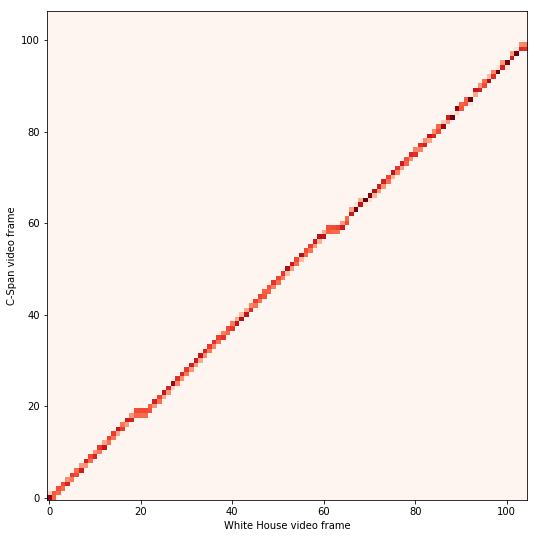

In [6]:
plt.figure(figsize=(9,9))
plt.xlabel('White House video frame')
plt.ylabel('C-Span video frame')
plt.imshow(frame_mappings, origin='bottom', cmap=plt.cm.Reds);

As you can see, there are a few blips where the altered video freezes for a few frames. This is not suspicious in itself, because it is a common artifact of framerate conversion.

We can approximate the timing of each White House frame by taking a weighted average of the two original frames it corresponds to:

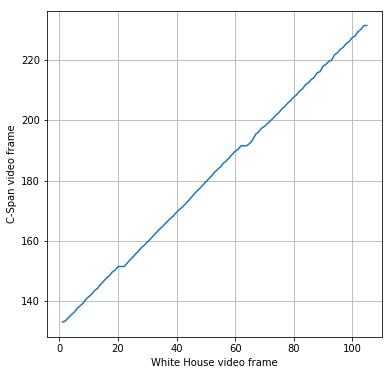

In [7]:
approx_frames = frame_mappings.T.dot(np.arange(ACTUAL_CLIP_START, ACTUAL_CLIP_END))

plt.figure(figsize=(6,6))
plt.grid(True)
plt.xlabel('White House video frame')
plt.ylabel('C-Span video frame')
plt.plot(np.arange(TWITTER_CLIP_START, TWITTER_CLIP_END), approx_frames);

Aside from a few frame freezes (which could be explained by frame rate conversion), the line has a pretty consistent slope. To be sure, we can compute plot the smoothed relative speed of the video over time. I've highlighted frames 26 - 39, where most of the action occurs and where I would have expected the video to be sped up, if at all.

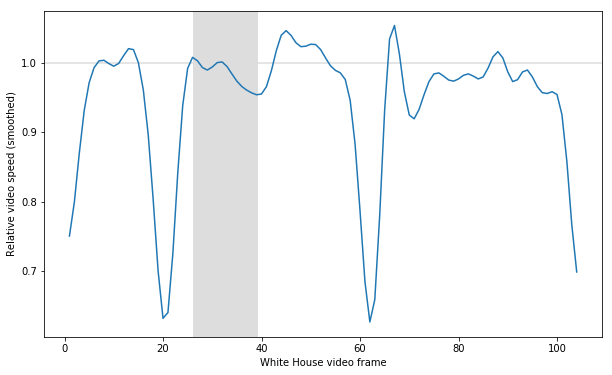

In [8]:
from scipy.ndimage.filters import gaussian_filter1d

plt.figure(figsize=(10, 6))
plt.axhline(1, zorder=-10, c='#dddddd')
plt.axvspan(26, 39, color='#dddddd')
plt.xlabel('White House video frame')
plt.ylabel('Relative video speed (smoothed)')
plt.plot(np.arange(TWITTER_CLIP_START, TWITTER_CLIP_END-1),
         gaussian_filter1d(approx_frames[1:] - approx_frames[:-1], 2.0));

As you can see, the video is actually relatively *slower* for most of this time range.

## Conclusion

I think this whole thing is an instance of [Hanlon's razor](https://en.wikipedia.org/wiki/Hanlon's_razor). The video appears edited because of shoddy video processing, but doesn't show evidence of being intentionally doctored.

That said, the video was a stupid distraction in the first place. Jim Acosta should get his press pass back.